# Imports

In [1]:
from javIA_oop import *

AI framework by Javi based in PyTorch: 0.4.1


# Load data

In [2]:
class SkinDataset(ImageDataset):

	def __init__(self, subset, transforms=False, limit=False):
		dataset_dir = pathlib.Path("D:/Datasets/TFM/ISIC-2017")
		csv_file    = dataset_dir / ("ground_truth_"+subset+".csv")
		csv_df      = pd.read_csv(csv_file)

		self.image_dir  = dataset_dir / ("data_"+subset)
		self.images     = (csv_df["image_id"]+".jpg").values
		self.labels     = csv_df.apply(self.get_label, axis=1).values
		self.labels_map = {0:"melanoma", 1:"seborrheic", 2:"healthy"}
		self.transforms = transforms
		self.limit      = limit

	def get_label(self, row):    
		label = row[1:3].values.tolist()
		if   label[0]==1.0: label=0   #"melanoma"
		elif label[1]==1.0: label=1   #"seborrheic_keratosis"
		else:               label=2   #"healthy"
		return label


dataset    = {subset: SkinDataset(subset) for subset in ["train", "valid", "test"]}
{print("There are", len(dataset[subset]), "images in the "+subset+" dataset.") for subset in ["train", "valid", "test"]};

There are 2000 images in the train dataset.
There are 150 images in the valid dataset.
There are 600 images in the test dataset.


# Check if data is balanced

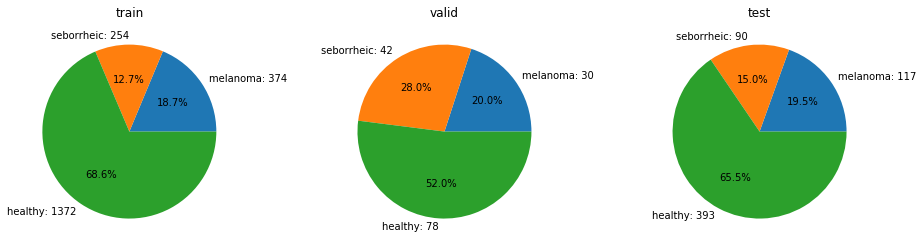

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, subset in enumerate(["train", "valid", "test"]):
    dataset[subset].plot_balance(axs[i], title=subset)

# Show data

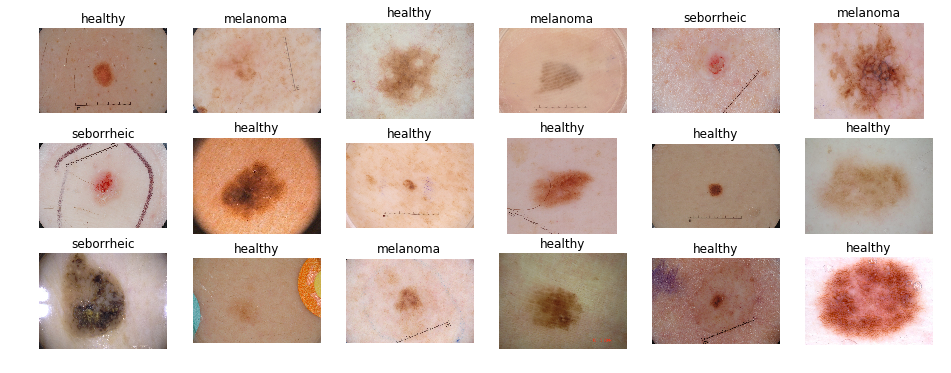

In [5]:
dataset["train"].plot_images(columns=6, rows=3)

# Min sizes of the images

In [7]:
for subset in ["train", "valid", "test"]:
    print(subset)
    min_sizes = dataset[subset].get_min_sizes()
    print("\tMinimun width  =",min_sizes['min_w'])
    print("\tMinimun height =",min_sizes['min_h'])

train
	Minimun width   = 576
	Minimun height  = 540
valid
	Minimun width   = 1024
	Minimun height  = 768
test
	Minimun width   = 639
	Minimun height  = 602


# Mean and std

In [5]:
dataset["valid"].get_mean_and_std()

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [01:02<00:00,  1.07s/it]


{'mean': [tensor(0.6926), tensor(0.5605), tensor(0.5103)],
 'std': [tensor(0.0934), tensor(0.0958), tensor(0.1102)]}

# Training

#### Data
- Preprocess: Subtracting global mean
- Deal imbalance: Oversampling minority classes (only in train set)
- Augmentations: Shear, rotation, ...
  
#### Model: Resnet18
- Resnet or Inception v3
- Last new layers: 
  1. Global average pooling layer
  2. Fully connected layer with 1024 nodes and activated with ReLU.
  3. Fully connected layer with 1 node output
- Batch size: 32
- Loss: binary_crossentropy
- Metric: accuracy


#### 1st traininig

- Unfreeze only the last new layers.
- Input size: 128x128 (resized)
- Epochs: 20
- Optimizer: Rmsprop
- Adaptive learning rate: Reduce the lr by a factor of 10, after 5 epochs of no accuracy improvement on the validation set.

#### 2nd training

- Unfreeze also the last two Inception/resnet blocks.
- Input size: 299x299 (resized)
- Epochs: EarlyStopping(monitor='val_acc', min_delta=0.01, patience=50, verbose=1, mode='auto') 
- Optimizer: stochastic gradient descent
- Learning rate: 1e-04,
- Momentum: 0.9
- Adaptive learning rate: ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=25, verbose=1))

## Evaluation

2 separate binary image classification tasks:

- Task 1 (melanoma vs nevus+seborrheic):
  - Val AUC: 0.76..0.78
  - Test Acc: 0.83
  - Avg Prec: 0.43
- Task 2 (melanoma+nevus vs seborrheic):
  - Val AUC: 0.84..0.87
  - Test Acc: 0.92
  - Avg Prec: 0.66
---

# Train
- Model: Resnet18

In [4]:
dl = DeepLearner(dataset, "resnet18")
epochs         = [0,1,2,3] #[0, 15, 30, 35]
learning_rates = [0, 0.1, 0.005, 0]
dl.train(epochs, learning_rates)

KeyboardInterrupt: 